<a href="https://www.kaggle.com/code/samithsachidanandan/sketch-predictor-cnn?scriptVersionId=289282365" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Published on December 26, 2025. By Prata, Marília (mpwolke)

Acknowledgements: [https://www.kaggle.com/code/mpwolke/sketch-predictor](https://www.kaggle.com/code/mpwolke/sketch-predictor)

## Step-by-Step Sketch Predictor Dataset

**Dataset's authors: Aqib Hussain Malik, Uns Ahmad, Musa Mehar, Houd Tariq**

Andrew Loomis Head Construction: Sequential Drawing Dataset

"This dataset provides a comprehensive collection of **175 unique head** drawing sequences based on the world-renowned Andrew Loomis construction method. Unlike static image datasets, this collection captures the temporal progression of a drawing—from initial geometric primitives to high-fidelity graphite renderings."

https://www.kaggle.com/datasets/aqibhussainmalik/step-by-step-sketch-predictor-dataset/data

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os
import glob
import random
import json

import random

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  
tf.get_logger().setLevel('ERROR')

import warnings

warnings.filterwarnings('ignore')



2025-12-30 18:26:27.028990: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767119187.184709      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767119187.232713      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767119187.607989      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767119187.608057      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767119187.608060      24 computation_placer.cc:177] computation placer alr

In [2]:
#By Inan https://www.kaggle.com/code/inanxr/prosopo-dataset/notebook

DATA_ROOT = '/kaggle/input/step-by-step-sketch-predictor-dataset'


# Get all identity folders
sketches = sorted(os.listdir(DATA_ROOT))
print(f'Total sketches: {len(sketches):,}')


# Count total images
image_paths = sorted(glob.glob(os.path.join(DATA_ROOT, '*', '*.jpg')))
head_images = sorted(glob.glob(os.path.join(DATA_ROOT, '*', 'head.png')))
print(f'Sketches and Heads images: {len(image_paths):,}, {len(head_images):,}')

CONFIG = {
    'image_size': (128, 128),
    'batch_size': 32,
    'epochs': 50,
    'seed': 42,
    'test_size': 0.2,
    'validation_split': 0.15 
}


IMAGE_SIZE = CONFIG['image_size']
BATCH_SIZE = CONFIG['batch_size']
EPOCHS = CONFIG['epochs']
SEED = CONFIG['seed']
TEST_SIZE = CONFIG['test_size']

Total sketches: 176
Sketches and Heads images: 1,670, 174


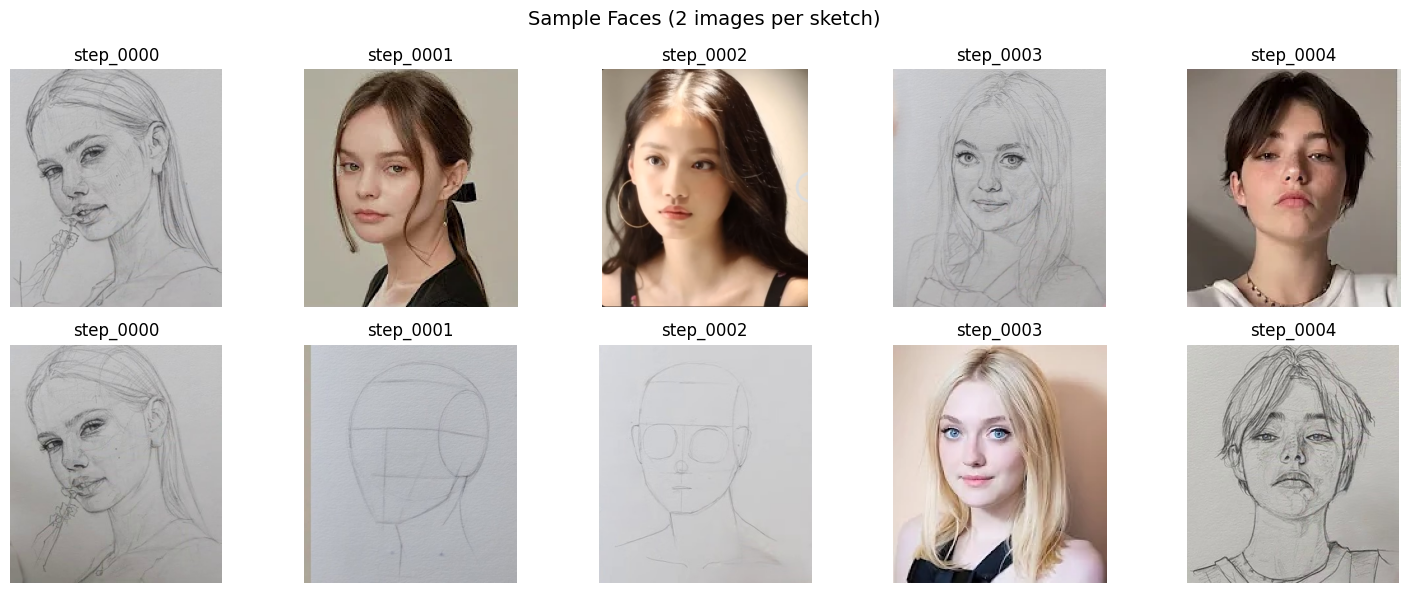

In [3]:
#By Inan https://www.kaggle.com/code/inanxr/prosopo-dataset/notebook

# Display sample faces from 5 random identities
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
sample_ids = random.sample(sketches, 5)

for i, sketch in enumerate(sample_ids):
    id_path = os.path.join(DATA_ROOT, sketch)
    images = os.listdir(id_path)[:2]  # Get 2 images per identity
    for j, img_name in enumerate(images):
        img = Image.open(os.path.join(id_path, img_name))
        axes[j, i].imshow(img)
        axes[j, i].axis('off')
        axes[j, i].set_title(f'step_{i:004d}')
   

plt.suptitle('Sample Faces (2 images per sketch)', fontsize=14)
plt.tight_layout()
plt.show()

## Load metadata.jsonl

In [4]:
##Code by StackOverflow https://stackoverflow.com/questions/50475635/loading-jsonl-file-as-json-objects

file = pd.read_json(path_or_buf= '../input/step-by-step-sketch-predictor-dataset/metadata.jsonl', lines=True)

file.tail()

,file_name,prompt
1841,99/step_0195.jpg,"loomis_sketch, Step 5, The sketch depicts a fa..."
1842,99/step_0228.jpg,"loomis_sketch, Step 6, The sketch depicts a fa..."
1843,99/step_0268.jpg,"loomis_sketch, Step 7, The shading is subtle a..."
1844,99/step_0312.jpg,"loomis_sketch, Step 8, The shading is subtle a..."
1845,99/step_0323.jpg,"loomis_sketch, Step 9, The shading is subtle a..."


In [5]:
import polars as pl

ten = pl.read_json('../input/step-by-step-sketch-predictor-dataset/10/metadata.json')

ten.head()

file_name,prompt
str,str
"""head.png""","""loomis_ref, reference sheet, f…"
"""step_0029.jpg""","""loomis_sketch, Step 1, The geo…"
"""step_0080.jpg""","""loomis_sketch, Step 2, The geo…"
"""step_0098.jpg""","""loomis_sketch, Step 3, The vis…"
"""step_0143.jpg""","""loomis_sketch, Step 4, The vis…"


In [6]:
df= pd.read_json('../input/step-by-step-sketch-predictor-dataset/10/metadata.json', orient=str)

df.head(3)

,file_name,prompt
0,head.png,"loomis_ref, reference sheet, finished characte..."
1,step_0029.jpg,"loomis_sketch, Step 1, The geometric construct..."
2,step_0080.jpg,"loomis_sketch, Step 2, The geometric construct..."


In [7]:
df['prompt'].value_counts()

prompt
loomis_ref, reference sheet, finished character concept art, high quality graphite rendering                                                                                                                                                                                                                                                                          1
loomis_sketch, Step 1, The geometric construction lines include a circle for the head, a cross-hairs for the forehead, and a jawline connection for the neck., graphite pencil on white paper                                                                                                                                                                         1
loomis_sketch, Step 2, The geometric construction lines include a circle for the head, a cross-hairs for the forehead, and a circle for the jawline., graphite pencil on white paper                                                                                             

In [8]:
df.iloc[0,1]


'loomis_ref, reference sheet, finished character concept art, high quality graphite rendering'

In [9]:
#By @jocelyndumlao

def load_and_preprocess_data(data_dir, image_size):
  
    images = []
    for image_path in image_paths:
        try:
            img = Image.open(image_path).convert('RGB').resize(image_size) 
            img_array = np.array(img) / 255.0  
            images.append(img_array)
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            continue 

    if not images:
        raise ValueError("No images were loaded from the directory.")

    images = np.array(images)
    labels = np.zeros(len(images))  

    return images, labels

In [10]:
#By @jocelyndumlao

try:
    images, labels = load_and_preprocess_data(DATA_ROOT, IMAGE_SIZE)
except ValueError as e:
    print(e)  
    exit()

In [11]:
#By @jocelyndumlao

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    images, labels, 
    test_size=0.2, 
    random_state=SEED,
    stratify=labels  
)
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")


Training data shape: (1336, 128, 128, 3)
Validation data shape: (334, 128, 128, 3)


In [12]:
def create_data_augmentation():
 
    return ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.15,
        shear_range=0.1,
        fill_mode='nearest'
    )


In [13]:
datagen = create_data_augmentation()
datagen.fit(X_train)

## CNN model

In [14]:


model = models.Sequential([
    layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),

    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
  
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    
 
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.35),
    

    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.45),
    layers.Dense(2, activation='softmax')
])

I0000 00:00:1767119214.915616      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [15]:
training_callbacks = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    
    callbacks.ModelCheckpoint(
        'best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

In [16]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 157,986 (617.13 KB)

 Trainable params: 157,090 (613.63 KB)

 Non-trainable params: 896 (3.50 KB)

## Epochs

In [17]:
EPOCHS = 50 
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE), 
    epochs=EPOCHS,
    validation_data=(X_val, y_val), 
    callbacks=training_callbacks, 
    verbose=1
)


Epoch 1/50


I0000 00:00:1767119220.510307      71 service.cc:152] XLA service 0x7a9dd005de80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767119220.510360      71 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1767119221.267329      71 cuda_dnn.cc:529] Loaded cuDNN version 91002


 3/42 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.4740 - loss: 1.1985 

I0000 00:00:1767119228.696384      71 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.5699 - loss: 0.9447
Epoch 1: val_loss improved from inf to 0.29868, saving model to best_model.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 25s 321ms/step - accuracy: 0.5712 - loss: 0.9410 - val_accuracy: 1.0000 - val_loss: 0.2987 - learning_rate: 0.0010
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.7435 - loss: 0.5329
Epoch 2: val_loss improved from 0.29868 to 0.15812, saving model to best_model.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.7446 - loss: 0.5319 - val_accuracy: 1.0000 - val_loss: 0.1581 - learning_rate: 0.0010
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.8712 - loss: 0.3411
Epoch 3: val_loss improved from 0.15812 to 0.11051, saving model to best_model.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.8716 - loss: 0.3403 - val_accuracy: 1.0000 - val_loss: 0.1105 - learning_rate: 0.0010
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9487 - loss:

## Model evaluation

In [18]:
# By @jocelyndumlao

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"\nFinal Validation Loss: {val_loss:.4f}")
print(f"Final Validation Accuracy: {val_accuracy:.4f}")


Final Validation Loss: 0.0001
Final Validation Accuracy: 1.0000


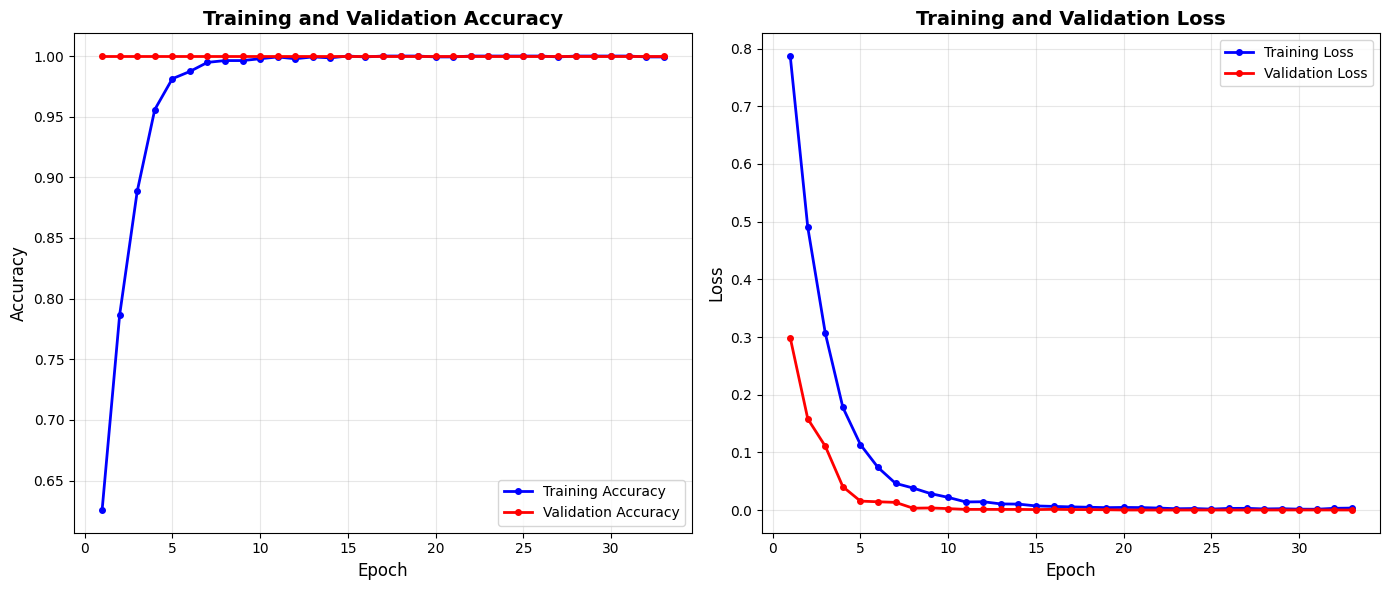


Training Summary:
Total epochs trained: 33
Best validation accuracy: 1.0000 (Epoch 1)
Final training accuracy: 0.9993
Final validation accuracy: 1.0000
Final training loss: 0.0034
Final validation loss: 0.0001



In [19]:
#By @jocelyndumlao

def plot_training_history(history):
    
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    

    epochs_range = range(1, len(acc) + 1)
    
    plt.figure(figsize=(14, 6))
    
  
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, 'b-o', label='Training Accuracy', linewidth=2, markersize=4)
    plt.plot(epochs_range, val_acc, 'r-o', label='Validation Accuracy', linewidth=2, markersize=4)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True, alpha=0.3)
    
  
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, 'b-o', label='Training Loss', linewidth=2, markersize=4)
    plt.plot(epochs_range, val_loss, 'r-o', label='Validation Loss', linewidth=2, markersize=4)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
  
    total_epochs = len(acc)
    best_epoch = val_acc.index(max(val_acc)) + 1
    print(f"\n{'='*50}")
    print(f"Training Summary:")
    print(f"{'='*50}")
    print(f"Total epochs trained: {total_epochs}")
    print(f"Best validation accuracy: {max(val_acc):.4f} (Epoch {best_epoch})")
    print(f"Final training accuracy: {acc[-1]:.4f}")
    print(f"Final validation accuracy: {val_acc[-1]:.4f}")
    print(f"Final training loss: {loss[-1]:.4f}")
    print(f"Final validation loss: {val_loss[-1]:.4f}")
    print(f"{'='*50}\n")



plot_training_history(history)

## Save Keras model

In [20]:
#By @jocelyndumlao

model.save("patterns_classifier.keras") # Saves the entire model to a HDF5 file
print("Model saved to patterns_classifier.keras")

Model saved to patterns_classifier.keras


## Prediction

In [21]:
#By @jocelyndumlao

# Choose a random image from the validation set
index = random.randint(0, len(X_val) - 1)
sample_image = X_val[index]
true_label = y_val[index]

In [22]:
#By @jocelyndumlao

# Add a batch dimension to the image (required by the model)
sample_image = np.expand_dims(sample_image, axis=0)

In [23]:
#By @jocelyndumlao

# Make a prediction
prediction = model.predict(sample_image)
predicted_label = 1 if prediction[0][0] > 0.5 else 0  # Threshold at 0.5

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step


## Display the image and prediction

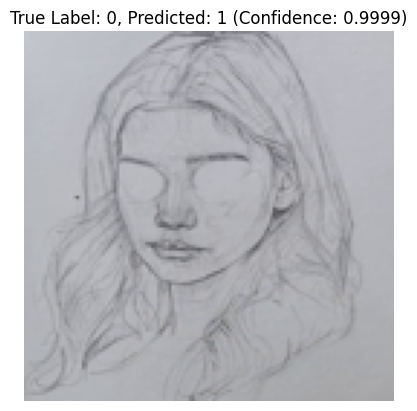

In [24]:
#By @jocelyndumlao

# Display the image and prediction
plt.imshow(X_val[index]) # show the original image instead of the batched one
plt.title(f"True Label: {int(true_label)}, Predicted: {predicted_label} (Confidence: {prediction[0][0]:.4f})")
plt.axis('off')
plt.show()

Sketch images


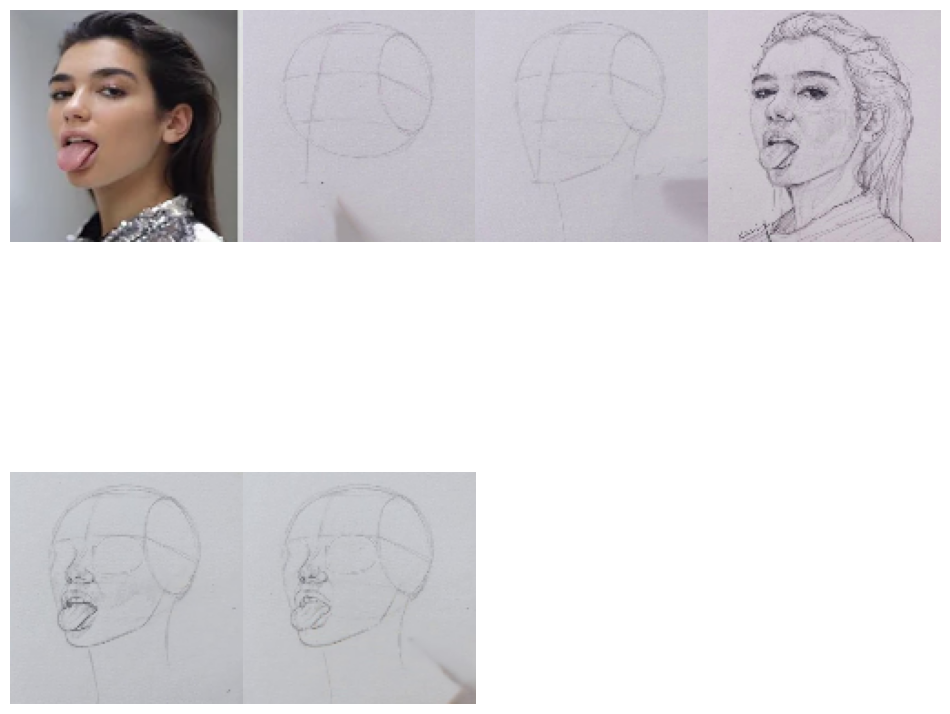

In [25]:
import cv2

def plotImages(tools,directory):
    print(tools)
    multipleImages = glob.glob(directory)
    plt.rcParams['figure.figsize'] = (12, 12) #Original is 15,15. Since we have 18 veggies I decreased the size
    plt.subplots_adjust(wspace=0, hspace=0)
    i_ = 0
    for l in multipleImages[:6]:
        im = cv2.imread(l)
        im = cv2.resize(im, (128, 128)) 
        plt.subplot(2, 4, i_+1) #.set_title(l)
        plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
        i_ += 1

plotImages("Sketch images","../input/step-by-step-sketch-predictor-dataset/100/**")

#Acknowledgements:

Jocelyn Dumlao

Inan https://www.kaggle.com/code/inanxr/prosopo-dataset/notebook